# Ordinary Differential Equations (ODEs)
If you give an object (e.g., large wooden rabbit) some initial velocity $v$ over a castle wall, then you will note that the vertical component of velocity gradually decreases.  Eventually, the vertical velocity component changes direction and the object (or wooden rabbit) impacts the ground with a speed roughly equal to the speed it had when it left.  

This example probably reminds you of the kinematics that you learned in your introductory physics course.  Resurrecting that prior knowledge wil assist you to develop intuitions to setup and solve ordinary differential equations (ODEs) numerically.  Through kinematics, we define an acceleration $\vec{a}$ as:

\begin{align}
\vec{a} = \frac{d\vec{v}}{dt},
\end{align}

 or 
 
\begin{align}
d\vec{v} = \vec{a} dt, 
\end{align}

with finite steps $d \rightarrow \Delta$.

However, we can perform a [Galilean transformation](https://en.wikipedia.org/wiki/Galilean_transformation) to make this result more general, which incorporates the initial velocity $v_o$ and then we can estimate the new velocity (given that we can calculate $a$).  Mathematically, this is:

\begin{align}
\vec{v} = \vec{v}_o + \vec{a}\Delta t.
\end{align}

Eventually, we'll want to change this into code.  This is much easier if we write the above equation as a [recurrence relation](https://en.wikipedia.org/wiki/Recurrence_relation), where the next value can be determined by the previous one:

\begin{align}
\vec{v}_{i+1} = \vec{v}_i + \frac{d\vec{v}}{dt}\Delta t.
\end{align}

```{note}
The index $i$ denotes the next value of a quantity *in time*.  The components of individual vectors are indexed using $j$.
```

Vector quantities are useful for us humans, but can be difficult for a computer to execute.  Thus, we define the position of the projectile along each direction $x_j$ in a position vector $\vec{x}$ and using the corresponding definition for velocity $v_j = dx_j/dt$ with the velocity vector $\vec{v}$:

\begin{align}
\vec{x} &= \{x_1,\ x_2,\ x_3 \} = \{ x,\ y,\ z \}, \\
\vec{v} &= \{v_1,\ v_2,\ v_3 \} = \{ v_x,\ v_y,\ v_z \}, \\
x_{i+1} &= x_i + v_i \Delta t.
\end{align}

This method does not give an exact result with a large $\Delta t$, but for a small enough $\Delta t$ it's close.  We can generalize further to define a state $\mathbf{y}=[\vec{x},\vec{v}]$ and use a single relation as:

\begin{align}
\mathbf{y} &= [\vec{x},\ \vec{v}], \\
\mathbf{y}_{i+1} &= [\vec{x}_i,\vec{v}_i] + \frac{d}{dt}[\vec{x}_i,\vec{v}_i]\Delta t.
\end{align}

## Euler's method
The method we've described is called *Euler's method* and it is a good first step in solving ODEs.  Let's consider a picture of how it works.  Starting from an initial point $(t_o,x_o)$, we estimate the slope of $x(t)$ between the current point and a time step $\Delta t$ forward to find the approximate value of $x_1$.  Because we used a recurrence relation, these steps can be repeated to find each step $x_i$ in the series of $x_n$.

The error through Euler's method can be large, but you can reduce the error introduced in the approximation by decreasing the time step $\Delta t$.  Essentially, you are decreasing the interval for the function $x(t)$ until it becomes approximately linear.  To determine the sensitivity of Euler's method relative to the step size $\Delta t$, we perform a Taylor expansion of $x(t)$ as:

\begin{align}
x(t+\Delta t) = x(t) + \frac{dx}{dt}\Delta t + \frac{d^2x}{dt^2}\frac{\Delta t^2}{2} + \cdots.
\end{align}

The first two terms on the right hand side are Euler's method and the error in each step is on the order of $\Delta t^2$, since that's the first term omitted in the Taylor series expansion.  However you accumulate error over the full time interval $\tau$ with the number of steps $N = \tau/\Delta t$, which changes the total error to $\Delta t$.  Notice that decreasing the step size $\Delta t$ improves your result linearly and Euler's method only works on first-order differential equations.  This means that if we can re-cast higher order differential equations into a series of first-order differential equations, then we have a very general method.

For example, let's explore the case of a **mass on a spring**.  The force of a spring is $\vec{F}_{spr} = m\vec{a} = -k\vec{x}$, where $k$ is a spring constant and $m$ is the mass.  This is a second-order ODE, but we can re-write the equations like in the introductory section with the Galilean transformation.  This involves a new variable $\vec{v} = d\vec{x}/dt$.  We have the following:

\begin{align}
\vec{a} = \frac{d{\vec{v}}}{dt} = -\frac{k}{m}\vec{x}\ \text{(original)}, 
\end{align}

which can be transformed as two coupled first-order differential equations

\begin{align}
\frac{d\vec{x}}{dt} &= \vec{v}, \\
\frac{d\vec{v}}{dt} &= -\frac{k}{m}{x}.
\end{align}

In python, we can write this as a function assuming 1D motion:

```python
def spring_force(dt,y,k,m):
    #function to calculate the spring force given a state y = [x,v]
    #dt = timestep; this is not used explicitly in this case, but could be in general
    #k = spring constant; m = mass
    #derivative of the state is dy/dt = [v,a]
    v = y[1]
    a = -k/m*y[0]
    return [v,a]
```

or in 3D:

```python
def spring_force(dt,y,k,m):
    #function to calculate the spring force given a state y = [x,y,z,vx,vy,vz]
    #dt = timestep; this is not used explicitly in this case, but could be in general
    #k = spring constant; m = mass
    #derivative of the state is dy/dt = [vx,vy,vz,ax,ay,az]
    vx, vy, vz = y[3], y[4], y[5]
    ax, ay, az = -k/m*y[0], -k/m*y[1], -k/m*y[2]
    return [vx,vy,vz,ax,ay,az]
```

## Standard Method for Solving ODEs
Here we develop a *standard model* for solving ODEs, which will be a blueprint for using different algorithms that have been developed.  This way it takes only a minimum amount of reprogramming to change between algorithms.  To start, consider the differential equation for a large wooden rabbit in free-fall with the *English pig-dogs* as the intended target:

\begin{align}
\ddot{x} = \frac{d^2}{dt^2} = -g,
\end{align}

where we've introduce the *dot* notation to make things a little easier when writing time derivatives and the above equation can be broken into two first-order equations:

\begin{align}
\dot{x} &= \frac{dx}{dt} = v, \\
\dot{v} &= \frac{dv}{dt} = -g.
\end{align}

The individual Euler solutions to those first-order equations are:

\begin{align}
x_{i+1} &= x_i + \dot{x}\Delta t, \\
v_{i+1} &= v_i + \dot{v}\Delta t.
\end{align}

There is a symmetry (which will help in producing code later) that lets you write them as a single vector equation:

\begin{align}
y_{i+1} = y_i + \dot{y}\Delta t,
\end{align}

where $y = [x,v]$ and $\dot{y} = [v,-g]$.  By writing the equations as vectors, we can better define the problem and change our thinking into one where **states** evolve.  Let's turn this into code:

In [2]:
def deriv_freefall(y,t):
    #function to define the derivatives need to solve the problem of free-fall
    #y is the current state and holds the variables [x,v] (position and first derivative)
    #t is the current time; not really used but kept for consistency
    yprime = np.zeros(len(y)) #derivative vector to be returned
    yprime[0] = y[1] #store the velocity
    yprime[1] = -9.8 #store the acceleration
    return yprime 

def Euler(y,t,dt,derivs):
    #function to implement Euler's method given the
    #y = [x,v] current state 
    #t = current time
    #dt = time step
    #derivs = derivative function that defines the problem
    y_next = y + derivs(y,t)*dt
    return y_next

The above functions include the time $t$ in their arguments, but it is not used in the functions at all.  This is on purpose because we want to create a general method, where in some other case the time variable could be more important.  Note also that the derivative function we created `deriv_freefall` is specific to the problem at hand, but the `Euler` function is completely general.

Using our standard method, let's put everything together to solve the mass on a spring problem but vertically.  **Will the forces will be different?**

Let's define the problem using code and see what we get:

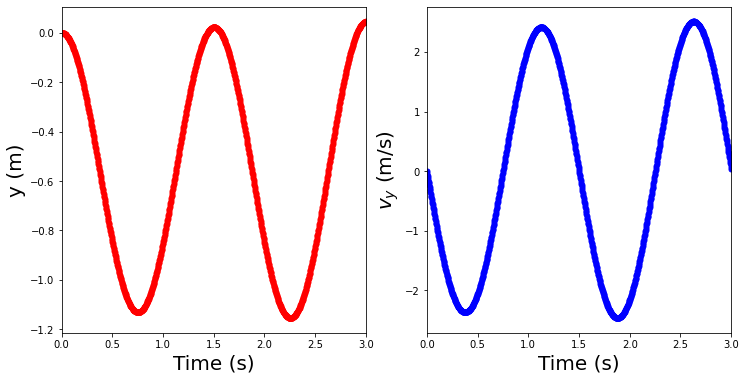

In [10]:
#SHO_Euler.py; Simple Harmonic motion (vertical mass on a spring)
import numpy as np
import matplotlib.pyplot as plt

N = 1000 #number of steps to take
y_o = 0.  #initial position (spring unstretched)
v_o = 0.  #starting at rest
tau = 3.  #total time for simulation (in seconds)
h = tau/float(N-1) #time step

k = 3.5 #spring constant (in N/m)
m = 0.2 #mass (in kg)
g = 9.8 #gravity (in m/s^2); new force since the spring is now vertical

states_Euler = np.zeros((N,2))  #storage for each state (used for plotting later)
times = np.arange(0,tau+h,h)
states_Euler[0,:] = [y_o,v_o] #set initial state (for completeness)

def Euler(y,t,h,derivs):
    #function to implement Euler's method
    #y = [x,v] current state 
    #t = current time
    #h = time step
    #derivs = derivative function that defines the problem
    y_next = y + derivs(y,t)*h
    return y_next

def SHO(x,time):
    #Simple Harmonic Oscillator
    #x = [y_t,v_t]; t = time (unused)
    #2nd order eqn: dy^2/dt^2 = -k/m y - g
    yp = np.zeros(2) #initialize return state
    yp[0] = x[1] #dy/dt = v_t
    yp[1] = -k/m*x[0] - g #dv/dt = -k/m y - g
    return yp

for i in range(0,N-1):
    #We obtain the i+1 state by feeding the ith state to Euler
    states_Euler[i+1,:] = Euler(states_Euler[i,:],times[i],h,SHO)

#Now let's visualize our results

fig = plt.figure(1,figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(times,states_Euler[:,0],'r.',ms=10)
ax2.plot(times,states_Euler[:,1],'b.',ms=10)

ax1.set_xlim(0,tau)
ax2.set_xlim(0,tau)

ax1.set_ylabel("y (m)",fontsize=20)
ax2.set_ylabel("$v_y$ (m/s)", fontsize=20)

ax1.set_xlabel("Time (s)",fontsize=20)
ax2.set_xlabel("Time (s)",fontsize=20);

Notice that we defined our time step using the total time and the number of steps.  **What do you think will happen we increase the time or decrease the number of steps?**  **Will the results be very different?**


## Runge-Kutta Methods
The most popular and general technique of solving ODE's is a set of methods called *Runge-Kutta* or **rk** methods.  The Runge-Kutta algorithms for integrating a differential equation are based upon the formal (exact) integral of a differential equation:

\begin{align}
\frac{dy}{dt} &= f(t,y) \implies y(t) = \int f(t,y) dt, \\
\Rightarrow y_{n+1} &= y_n + \int_{t_n}^{t_{n+1}} f(t,y) dt.
\end{align}

To derive the second-order Runge-Kutta algorithm (**rk2**), we expand $f(t,y)$ in a Taylor series about the *midpoint* of the integration interval and retain two terms:

\begin{align}
f(t,y) \simeq f(t_{n+1/2},y_{n+1/2}) + (t-t_{n+1/2})\frac{df}{dt}(t_{n+1/2}) + O(h^2).
\end{align}

Because $(t-t_{n+1/2})$ to any odd power is symmetric (equally positive and negative) over the interval $t_n\leq t \leq t_{n+1}$, the integral of the second term with $(t-t_{n+1/2})$ vanishes and we obtain our algorithm:

\begin{align}
\int_{t_n}^{t_{n+1}} &\simeq f(t_{n+1/2},y_{n+1/2})h + O(h^3), \\
\implies y_{n+1} &\simeq y_n + f(t_{n+1/2},y_{n+1/2})h + O(h^3).\qquad  \text{\bf (rk2)}
\end{align}

We should notice that while **rk2** contains the same number of terms as Euler's rule, it obtains a higher level of precision by taking advantage of the cancellation of the $O(h)$ terms (recall something similar happened when comparing Trapezoid to Simpson's rule).  The price for improved precision is having to evaluate the derivative function and $y$ at the middle of the time interval, $t = t_n + h/2$.  

But, we don't have a function to evaluate at this point!  The way out of this quagmire is to ues Euler's algorithm for the midpoint $y_{n+1/2}$:

\begin{align}
y_{n+1/2} \simeq y_n + \frac{h}{2}\frac{dy}{dt}=y_n + \frac{h}{2}f(t_n,y_n).
\end{align}

Combining the above expression with our equation for **rk2**, we get:

\begin{align}
y_{n+1} &\simeq y_n + k_2, \qquad  \text{\bf (rk2)} \\
k_2 &= hf(t_n+h/2,y_n+k_1/2), \\
k_1 &= hf(t_n,y_n),
\end{align}

where $y$ is a state vector (and hence $f(t,y)$ is a state vector too).  The known derivative function $\frac{dy}{dt} = f(t,y)$ is evaluated at the ends and the midpoint of the interval, but only the known initial value of the $y$ is required.  This makes the algorithm self-starting.  Just like how we expanded our integration methods to consider more steps, we can do the same with **rk2** to get **rk4**.  Here is the algorithm for **rk4**:

\begin{align}
& &y_{n+1} = y_n + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4), \\
k_1 &= hf(t_n,y_n), &k_2 &= hf(t_n+h/2,y_n+0.5k_1), \\
k_3 &= hf(t_n+h/2,y_n+0.5k_2), &k_4 &= hf(t_n+h,y_n+k_3).
\end{align}

Let's apply this to our previous problem of the mass on a spring in code!

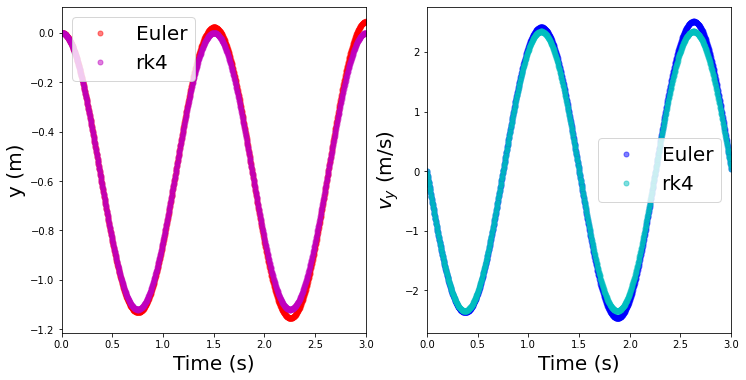

In [17]:
#SHO_rk4.py; Simple Harmonic motion (vertical mass on a spring)
import numpy as np
import matplotlib.pyplot as plt

N = 1000 #number of steps to take
y_o = 0.  #initial position (spring unstretched)
v_o = 0.  #starting at rest
tau = 3.  #total time for simulation (in seconds)
h = tau/float(N-1) #time step

k = 3.5 #spring constant (in N/m)
m = 0.2 #mass (in kg)
g = 9.8 #gravity (in m/s^2); new force since the spring is now vertical

states_rk4 = np.zeros((N,2))  #storage for each state (used for plotting later)
times = np.arange(0,tau+h,h)
states_rk4[0,:] = [y_o,v_o] #set initial state (for completeness)

def rk4(y,t,h,derivs):
    #function to implement rk4
    #y = [x,v] current state 
    #t = current time
    #h = time step
    #derivs = derivative function that defines the problem
    k1,k2,k3,k4 = np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)
    k1 = h*derivs(y,t) 
    y_halfstep = y + k1/2. #Euler half step using k1
    k2 = h*derivs(y_halfstep,t+h/2)
    y_halfstep = y + k2/2. #Euler half step using k2
    k3 = h*derivs(y_halfstep,t+h/2)
    k4 = h*derivs(y + k3,t+h) #full step using k3
    y_next = y + (k1+2*k2+2*k3+k4)/6.   
    return y_next

def SHO(x,time):
    #Simple Harmonic Oscillator
    #x = [y_t,v_t]; t = time (unused)
    #2nd order eqn: dy^2/dt^2 = -k/m y - g
    yp = np.zeros(2) #initialize return state
    yp[0] = x[1] #dy/dt = v_t
    yp[1] = -k/m*x[0] - g #dv/dt = -k/m y - g
    return yp

for j in range(0,N-1):
    #We obtain the j+1 state by feeding the j state to rk4
    states_rk4[j+1,:] = rk4(states_rk4[j,:],times[j],h,SHO)

#Now let's visualize our results

fig = plt.figure(1,figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(times,states_Euler[:,0],'r.',ms=10,alpha=0.5,label='Euler')
ax2.plot(times,states_Euler[:,1],'b.',ms=10,alpha=0.5,label='Euler')

ax1.plot(times,states_rk4[:,0],'m.',ms=10,alpha=0.5,label='rk4')
ax2.plot(times,states_rk4[:,1],'c.',ms=10,alpha=0.5,label='rk4')

ax1.set_xlim(0,tau)
ax2.set_xlim(0,tau)

ax1.legend(loc='best',fontsize=20)
ax2.legend(loc='best',fontsize=20)

ax1.set_ylabel("y (m)",fontsize=20)
ax2.set_ylabel("$v_y$ (m/s)", fontsize=20)

ax1.set_xlabel("Time (s)",fontsize=20)
ax2.set_xlabel("Time (s)",fontsize=20);

The above plots show the differences between **Euler** and **rk4**, where the solutions for the position are virtually identical, but the differences in velocity are more substantial.  The **rk4** is the more accurate and versatile of the two methods.  There are high-order methods with adaptive step sizes, which you can find in [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html).  Here is an example function

`scipy.integrate.RK45(fun, t0, y0, t_bound=tau, max_step=h, rtol=0.001, atol=1e-06)`,

where `fun` defines the derivative function (`SHO` in our case), `t0` is the initial time, `y0` is the initial **state**, `t_bound` is the final time, `max_step` is the maximum step size that we limit to h, `rtol` is a relative error tolerance level, and `atol` is the absolute error tolerance level.

Let's evaluate a more difficult problem using the mass on a spring, where we include a friction coefficient.

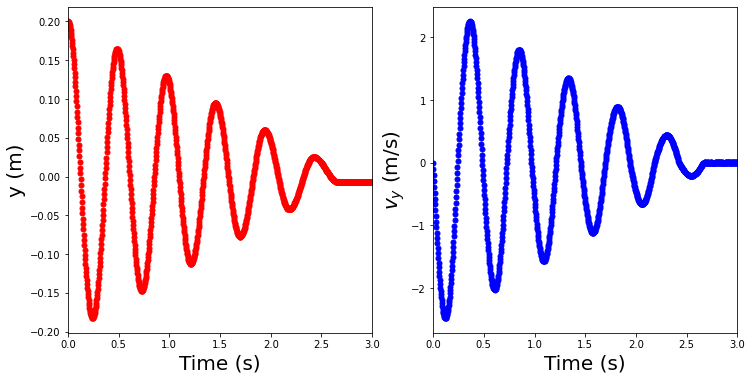

In [15]:
#SHO_rk4_friction.py; Simple Harmonic motion (vertical mass on a spring)
import numpy as np
import matplotlib.pyplot as plt

N = 1000 #number of steps to take
y_o = 0.2  #initial position (spring unstretched)
v_o = 0.  #starting at rest
tau = 3.  #total time for simulation (in seconds)
h = tau/float(N-1) #time step

k = 42 #spring constant (in N/m)
m = 0.25 #mass (in kg)
g = 9.8 #gravity (in m/s^2); new force since the spring is now vertical
mu = 0.15 #coefficient of friction

states_rk4_fric = np.zeros((N,2))  #storage for each state (used for plotting later)
times = np.arange(0,tau+h,h)
states_rk4_fric[0,:] = [y_o,v_o] #set initial state (for completeness)

def rk4(y,t,h,derivs):
    #function to implement rk4
    #y = [x,v] current state 
    #t = current time
    #h = time step
    #derivs = derivative function that defines the problem
    k1,k2,k3,k4 = np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)
    k1 = h*derivs(y,t) 
    y_halfstep = y + k1/2. #Euler half step using k1
    k2 = h*derivs(y_halfstep,t+h/2)
    y_halfstep = y + k2/2. #Euler half step using k2
    k3 = h*derivs(y_halfstep,t+h/2)
    k4 = h*derivs(y + k3,t+h) #full step using k3
    y_next = y + (k1+2*k2+2*k3+k4)/6.   
    return y_next

def SHO(x,time):
    #Simple Harmonic Oscillator
    #x = [y_t,v_t]; t = time (unused)
    #2nd order eqn: dy^2/dt^2 = -k/m y - g
    yp = np.zeros(2) #initialize return state
    yp[0] = x[1] #dy/dt = v_t
    if yp[0] > 0: #check if velocity is positive
        yp[1] = -k/m*x[0] - g*mu #dv/dt = -k/m y - g mu; w/friction
    else: #check if velocity is positive
        yp[1] = -k/m*x[0] + g*mu #dv/dt = -k/m y + g mu; w/friction
    return yp

for j in range(0,N-1):
    #We obtain the j+1 state by feeding the j state to rk4
    states_rk4_fric[j+1,:] = rk4(states_rk4_fric[j,:],times[j],h,SHO)

#Now let's visualize our results

fig = plt.figure(1,figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.plot(times,states_rk4[:,0],'k.',ms=10)
#ax2.plot(times,states_rk4[:,1],'k.',ms=10)

ax1.plot(times,states_rk4_fric[:,0],'r.',ms=10)
ax2.plot(times,states_rk4_fric[:,1],'b.',ms=10)

ax1.set_xlim(0,tau)
ax2.set_xlim(0,tau)

ax1.set_ylabel("y (m)",fontsize=20)
ax2.set_ylabel("$v_y$ (m/s)", fontsize=20)

ax1.set_xlabel("Time (s)",fontsize=20)
ax2.set_xlabel("Time (s)",fontsize=20);

## Problems

Complete the following problems in a Jupyter notebook, where you will save your results as an external file (*.png).

Create a $\LaTeX$ document with:

- an abstract summary
- sections for each problem that **state** the problem, **explain** your approach to solving the problem, and **display** the results
- include a reference for each solution (this can be textbooks) 

```{admonition} Problem 1

**Express each of these differential equations as a set of [first-order differential equations](https://tutorial.math.lamar.edu/classes/de/systemsde.aspx) and write an appropriate `derivs` function:**

**(a)**   $m\ddot{x} = f(x,t)$

**(b)**    $A\ddot{x} + B\dot{x} + Cx = D$

**(c)**   $m\ddot{\theta} = -\sqrt{g/L}\sin \theta - \beta\dot{\theta}+ \gamma\sin \omega t$

```

```{admonition} Problem 2
**Write a Python program to study projectile motion without air resistance using rk4**.  Then apply your program to the following scenario:

You are a pirate cannoneer and your Captain (*Jack Sparrow*) has ordered you to fire the cannon to escape the clutches of Davy Jones.  Your Captain wants to make a quick getaway because he knows of the stench from the Kraken. Thus, you must make a direct hit on the first shot.  The cannon has a muzzle speed of about 400 m/s and the firing deck is 15 m above sea level.  The Captain is sailing at max speed, where Davy Jones is matching Sparrow's velocity and keeping a constant 12.2 km between your cannon and his bow.  The main mast of the Flying Dutchman is located an additional 25 m beyond the bow.  

**(a)**  At what angle (from the horizontal) must you fire the cannon to hit the mast of the Flying Dutchman?

**(b)**  What is the maximum height (from sea level) will the cannonball fly?

**(c)**  Compare your results to expectations from theory (i.e., the kinematics you learned in pirate school).  Plot the trajectory (x,y), maximum height, and range determined from your program along with analytic values.

```

```{admonition} Problem 3   
**Write a Python program to evaluate the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) using rk4**.  The differential equations are:

\begin{align}
\frac{dx}{dt} &= \sigma(y-x), \\
\frac{dy}{dt} &= x(\rho-z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{align}

**(a)**  Assume that $\sigma = 10$ and $\beta = 8/3$, but $\rho = [13,14,15,28]$.  Evaluate using each value of $\rho$ separately.

**(b)**  Plot the z vs. x plane of the above solutions.
```